In [1]:
from classy_sz import Class


import sys
sys.path.insert(1,'../code/')

import estim 


import importlib
importlib.reload(estim)

import config as conf
import numpy as np
from matplotlib import pyplot as plt

#Initialize the estimator class. To do so, you have to provide the l_max for your precomputed Cl data (here 6144)
#and you also need the configuration module used when calculating the Cls

NBIN = 4

conf.N_bins = NBIN


import healpy as hp
import recon_MaxL as rml

import pickle
import loginterp


In [2]:

c_mps=299792458
c_kmps = c_mps/1000

In [16]:
importlib.reload(estim)

<module 'estim' from '/mnt/home/fmccarthy/ksz/final_ReCCO/ReCCO/notebooks/../code/estim.py'>

In [17]:


EST = estim.estimator(data_lmax = 6144,conf_module = conf,lss='taud',
                     CMB_experiment='SO')
EST.set_Nfine(8)


EST.include_Tlss=False
EST.nbin_tracer = 1

EST.conf.LSSexperiment='LSST'
EST.CMB_experiment='whitenoise1e-20'

Default lss = 'g' . Modify with set_lss method.
Default N_fine_modes = 4. Modify with set_Nfine method.
N_fine_modes reset to 8


In [18]:
EST.zb.zbins_chi

array([  43.98392527, 1937.72011839, 3831.4563115 , 5725.19250461,
       7618.92869772])

In [19]:
nside = 4096

websky_maps_folder = '/mnt/ceph/users/fmccarthy/kSZ/Websky_sims/'


kszmap = hp.fitsfunc.read_map(websky_maps_folder + 'ksz.fits')/(1e6*2.7)
kszcl = hp.anafast(kszmap)


CMB_alm = hp.fitsfunc.read_alm(websky_maps_folder+'lensed_alm.fits')/(1e6*2.7)
CMBmap = hp.alm2map(CMB_alm,nside=nside)

CMBmap = hp.alm2map(CMB_alm,nside)
CMBcl = hp.alm2cl(CMB_alm)


CIBmap = hp.fitsfunc.read_map(websky_maps_folder + 'cib_nu0545.fits')*1e6   #CIB in Jy
CIBcl = hp.anafast(CIBmap)


nside = 4096
resolution_in_steradians=hp.nside2resol(nside, arcmin=False)**2

CIBmap_removepoints = CIBmap.copy()
CIBmap_removepoints[CIBmap_removepoints>0.4/resolution_in_steradians]=np.mean(CIBmap_removepoints[CIBmap_removepoints>0.4/resolution_in_steradians])   #remove point sources above 400 mJy
CIBmap_removepoints_cl = hp.anafast(CIBmap_removepoints)

In [20]:
1

1

In [10]:
vmaps_full = np.zeros((NBIN,kszmap.shape[0]))
for x in range(0,NBIN):
        chimin = EST.zb.zbins_chi[x]
        chimax = EST.zb.zbins_chi[x+1]
        #chimin = CHIS[x]
        #chimax = CHIS[x+1]
        
       # taumaps_full[x] = hp.fitsfunc.read_map(websky_maps_folder +'tau_chimin'+str(int(chimin))+'_chimax'+str(int(chimax))+'_NSIDE4096.fits')
        vmaps_full[x] = hp.fitsfunc.read_map(websky_maps_folder +'vrad_chimin'+str(int(chimin))+'_chimax'+str(int(chimax))+'_NSIDE4096.fits')/c_kmps



In [11]:
cl_folder = '/mnt/ceph/users/fmccarthy/kSZ/final_ReCCO/output/912a6b556422e36932684b9d5881dfc6/Cls/'

In [12]:
Lsamp = pickle.load(open(cl_folder + 'L_sample_lmax=6144.p','rb'))
cl_taudcib = pickle.load(open(cl_folder +'Pi_bins='+str(NBIN)+'/Ae=1/Cl_taud_CIB(545)_lmax=6144.p','rb'))
cl_taudcib.shape

(96, 4, 1)

In [13]:
cl_cross = loginterp.log_interpolate_matrix(cl_taudcib, Lsamp)

In [14]:
def jy_to_uK(nu):
    #jy to microK

    frequencies=[100,143,217,353,545,857]

    if nu in frequencies:
        conversions=[244.1,371.74,483.69,287.45,58.04,2.27]
        return 1/conversions[frequencies.index(nu)]

    else:
        x=nu/56.8
        conversionfactor=1.05e3*(np.exp(x)-1)**2*np.exp(-x)*(nu/100)**-4
        return 1/(1/conversionfactor*1e6)

In [21]:
Cls={}
Cls['T-T'] = kszcl[:6145,None,None]
Cls['lss-lss'] = np.zeros((6145,NBIN,NBIN))#CIBcl[:6145,None,None]
Cls['taud-lss']= np.zeros((6145,NBIN,NBIN))#np.transpose(cl_cross,(0,2,1))*1/jy_to_uK(545)
Cls['lss-taud']= np.zeros((6145,NBIN,NBIN))#np.transpose(cl_cross,(0,2,1))*1/jy_to_uK(545)


for x in range(0,NBIN):
        Cls['taud-lss'][:,x,x] = cl_cross[:,x,0]*1/jy_to_uK(545)
        Cls['lss-lss'][:,x,x] = CIBcl[:6145]
        for y in range(0,NBIN): 
            Cls['lss-lss'][:,x,y] = CIBcl[:6145]
            Cls['taud-lss'][:,x,y] = cl_cross[:,x,0]*1/jy_to_uK(545)
            Cls['lss-taud'][:,x,y] = cl_cross[:,y,0]*1/jy_to_uK(545)
Cls['lss-taud']=Cls['taud-lss'].copy() #cl_cross*1/jy_to_uK(545)
Cls['T-lss']= np.zeros((6145,1,NBIN))
Cls['lss-T']= np.zeros((6145,NBIN,1))

EST.estim_dir = 'estim/'+estim.c.get_hash(estim.c.get_basic_conf(EST.conf, exclude = False))+'/'+EST.lss+'_T_freq='+str(None)+EST.CMB_experiment+'/'
EST.set_theory_Cls(Cls_dict=Cls)

nsidein = 2048
nsideout= 32

ksz_dgraded = hp.ud_grade(kszmap,nsidein)
CIB_dgraded = hp.ud_grade(CIBmap_removepoints,nsidein)

CMB_dgraded =hp.alm2map(CMB_alm,nsidein)

qe,noise,R =  EST.reconstruct_velocity_from_maps(ksz_dgraded,np.array([CIB_dgraded for x in range(0,NBIN)]),nsidein,nsideout,fast=True)

vtrue = hp.ud_grade(vmaps_full,nsideout)

EST.Cls['T-T'] = kszcl[:6145,None,None] + CMBcl[:6145,None,None]

qe_withcmb,noise_withcmb,R_withCMB =  EST.reconstruct_velocity_from_maps(ksz_dgraded+CMB_dgraded,np.array([CIB_dgraded for x in range(0,NBIN)]),nsidein,nsideout,fast=True)


calculating noise
calculating noise
Theory noise ready
done
calculating reconstruction


done in 51.23428153991699
calculating noise
calculating noise
Theory noise ready
done
calculating reconstruction
done in 55.15682506561279


In [22]:

nsideout= 32
vtrue = hp.ud_grade(vmaps_full,nsideout)
vtrue_Rot = np.matmul(R,vtrue)
vtrue_Rot_cmb = np.matmul(R_withCMB,vtrue)


array([  0.        , 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76818779,
       109.76818779, 109.76818779, 109.76818779, 109.76

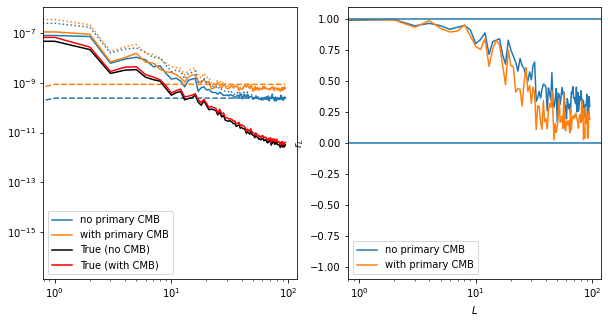

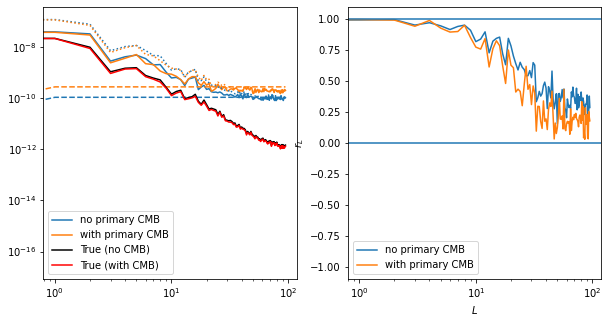

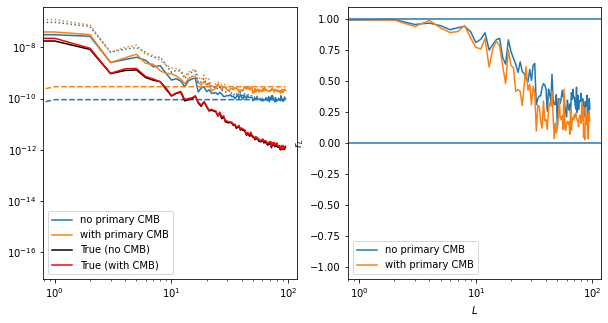

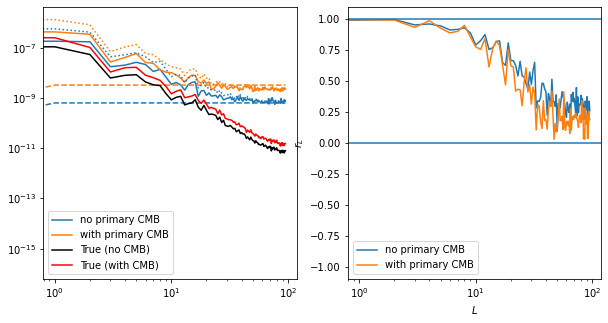

In [25]:
for x in range(0,NBIN):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    l1,=plt.loglog(hp.anafast(qe[x]/1e6),label='no primary CMB')
    l2,=plt.loglog(hp.anafast(qe_withcmb[x]/1e6),label='with primary CMB')

    plt.plot(noise[x,x]/1e6**2,color=l1.get_color(),ls='--')
    plt.plot(noise_withcmb[x,x]/1e6**2,color=l2.get_color(),ls='--')

    plt.loglog(hp.anafast(vtrue_Rot[x]),label='True (no CMB)',color='black') 
    plt.loglog(hp.anafast(vtrue_Rot_cmb[x]),label='True (with CMB)',color='red') 


    
    plt.loglog(hp.anafast(vtrue_Rot[x]-qe[x]/1e6),color=l1.get_color(),ls=':')
    plt.loglog(hp.anafast(vtrue_Rot_cmb[x]-qe_withcmb[x]/1e6),color=l2.get_color(),ls=':')


    plt.legend()
    plt.subplot(122)

    crosscor = hp.anafast(qe[x],vtrue_Rot[x])/np.sqrt(hp.anafast(qe[x])*hp.anafast(vtrue_Rot[x]))

    crosscor_cmb = hp.anafast(qe_withcmb[x],vtrue_Rot_cmb[x])/np.sqrt(hp.anafast(qe_withcmb[x])*hp.anafast(vtrue_Rot_cmb[x]))
    plt.plot(-crosscor,label='no primary CMB')
    plt.plot(-crosscor_cmb,label='with primary CMB')

    plt.xscale("log")
    plt.xlabel(r"$L$")
    plt.ylabel(r"$r_L$")
    plt.axhline(1)
    plt.axhline(0)

    plt.legend()
    plt.show()

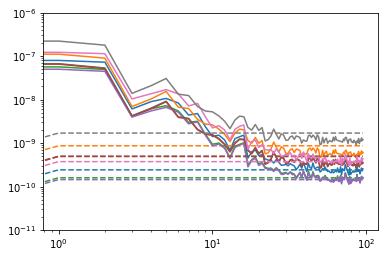

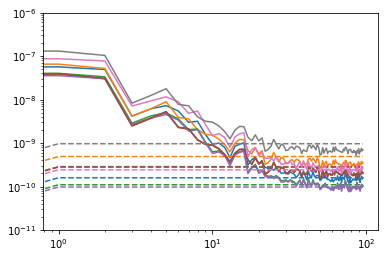

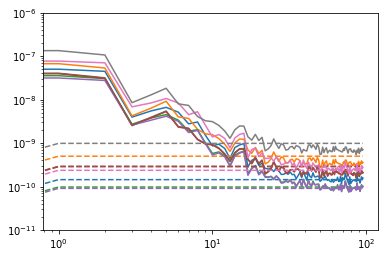

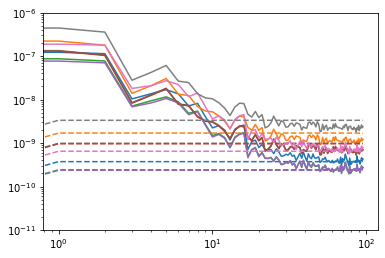

In [33]:
for x in range(0,NBIN):
    for y in range(0,NBIN):
        l1,=plt.loglog(hp.anafast(qe[x]/1e6,qe[y]/1e6),label='no primary CMB')
        l2,=plt.loglog(hp.anafast(qe_withcmb[x]/1e6,qe_withcmb[y]/1e6),label='with primary CMB')

        plt.plot(noise[x,y]/1e6**2,color=l1.get_color(),ls='--')
        plt.plot(noise_withcmb[x,y]/1e6**2,color=l2.get_color(),ls='--')

      #  plt.loglog(hp.anafast(vtrue_Rot[x],vtrue_Rot[y]),label='True (no CMB)',color='black') 
      #  plt.loglog(hp.anafast(vtrue_Rot_cmb[x],vtrue_Rot_cmb[y]),label='True (with CMB)',color='red') 
    plt.ylim(1e-11,1e-6)
    plt.show()

### what are we reconstructing?

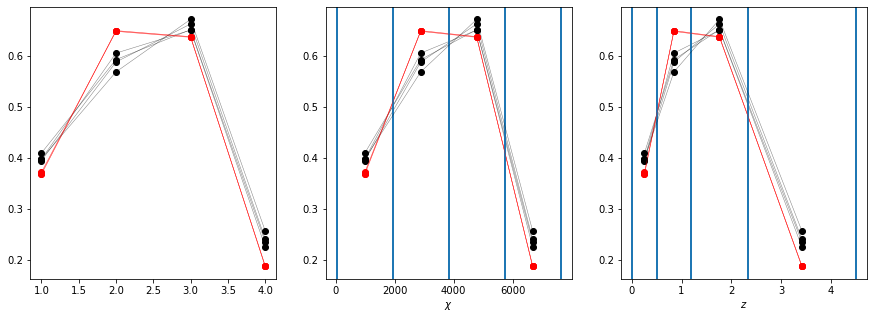

In [205]:
plt.figure(figsize=(15,5))
for x in range(0,NBIN):
    for y in range(0,3):
        plt.subplot(1,3,y+1)
        if y==0:
            xaxis = np.arange(1,NBIN+1)
        elif y ==1:
            xaxis = (EST.zb.zbins_chi[1:]+ EST.zb.zbins_chi[:-1])/2
            plt.xlabel(r"$\chi$")
            for chi in EST.zb.zbins_chi:
                plt.axvline(chi)
        elif y==2:
            xaxis = (EST.zb.zbins_z[1:]+ EST.zb.zbins_z[:-1])/2
            plt.xlabel(r"$z$")


            for z in EST.zb.zbins_z:
                plt.axvline(z)

        plt.plot(xaxis,R[x]/np.linalg.norm(R[x]),'black',alpha=0.5,lw=0.5)
        plt.plot(xaxis,R[x]/np.linalg.norm(R[x]),'o',color='black',)


        plt.plot(xaxis,R_withCMB[x]/np.linalg.norm(R_withCMB[x]),'red',alpha=0.5,lw=0.5)
        plt.plot(xaxis,R_withCMB[x]/np.linalg.norm(R_withCMB[x]),'o',color='red',)

plt.show()

### Principle components

In [94]:
def diagonalize(matrix):
    
    eigenvalues,eigenvectors = np.linalg.eig(matrix)
    transformed_matrix = np.matmul(np.matmul(np.transpose(eigenvectors),matrix),(eigenvectors))
    return np.transpose(eigenvectors), transformed_matrix
def to_identity(matrix):
    eigenvalues,eigenvectors = np.linalg.eig(matrix)
    transformation = 1/np.sqrt(matrix.diagonal())*np.identity(NBIN)
    transformed_matrix  = np.matmul(np.matmul(transformation,matrix),np.transpose(transformation))
    return transformation,transformed_matrix

In [124]:
def diagonalize_signalandnoise(signal,noise):
    first_transformation,noise = diagonalize(noise.copy())
    signal = np.matmul(np.matmul(first_transformation,signal),np.transpose(first_transformation))
    second_transformation,noise = to_identity(noise.copy())
    signal = np.matmul(np.matmul(second_transformation,signal),np.transpose(second_transformation))
    third_transformation,signal = diagonalize(signal.copy())
    return np.matmul(third_transformation,np.matmul(second_transformation,first_transformation)),signal.copy()

In [147]:
noise.shape
signal = np.zeros(noise.shape)
for x in range(0,4):
    for y in range(0,4):
        signal[x,y,1:] = hp.anafast(vtrue_Rot[x]*1e6,vtrue_Rot[y]*1e6)[1:]

signal_withCMB = np.zeros(noise.shape)
for x in range(0,4):
    for y in range(0,4):
        signal_withCMB[x,y,1:] = hp.anafast(vtrue_Rot_cmb[x]*1e6,vtrue_Rot_cmb[y]*1e6)[1:]




In [151]:
s2n = np.zeros(signal.shape)
transformation = np.zeros((NBIN,NBIN,signal.shape[-1]))
for ellind in np.arange(1,96):
    transformation[:,:,ellind],s2n[:,:,ellind] = diagonalize_signalandnoise(signal[:,:,ellind].copy(),noise[:,:,ellind].copy())
    
s2n_withcmb = np.zeros(signal.shape)
transformation_withcmb = np.zeros((NBIN,NBIN,signal.shape[-1]))
for ellind in np.arange(1,96):
    transformation_withcmb[:,:,ellind],s2n_withcmb[:,:,ellind] = diagonalize_signalandnoise(signal_withCMB[:,:,ellind].copy(),noise_withcmb[:,:,ellind].copy())

    
    

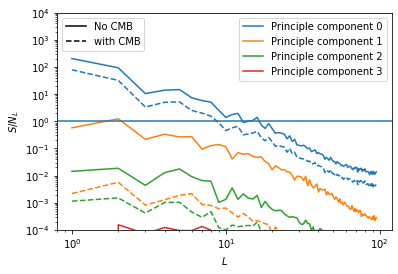

In [166]:
figure=plt.figure()
ax = plt.subplot(111)

nocmb,=plt.plot(1,1,color='black',ls='-')

withcmb,=plt.plot(1,1,color='black',ls='--')

leg2 = plt.legend([nocmb,withcmb],['No CMB','with CMB'],loc='upper left')
for x in range(0,NBIN):
    l1,=plt.plot(np.arange(1,96),s2n[x,x,1:],label='Principle component '+str(x))
    plt.plot(np.arange(1,96),s2n_withcmb[x,x,1:],color=l1.get_color(),ls='--')
leg1 = plt.legend()

plt.yscale("log")
plt.axhline(1)
plt.xscale("log")
plt.xlabel(r"$L$")
plt.ylabel(r"$S/N_L$")
plt.ylim(1e-4,1e4)
ax.add_artist(leg2)


In [168]:
R

array([[1.        , 1.44659702, 1.58935119, 0.57620508],
       [0.65717837, 1.        , 1.07427434, 0.37385027],
       [0.59645091, 0.88743048, 1.        , 0.36470347],
       [1.5462348 , 2.20831163, 2.60785488, 1.        ]])

In [175]:
total_trans = np.zeros(transformation.shape)
for ellind in range(0,transformation.shape[-1]):
    total_trans[:,:,ellind] = np.matmul(transformation[:,:,3],R)
total_trans_withCMB = np.zeros(transformation.shape)
for ellind in range(0,transformation.shape[-1]):
    total_trans_withCMB[:,:,ellind] = np.matmul(transformation_withcmb[:,:,3],R_withCMB)

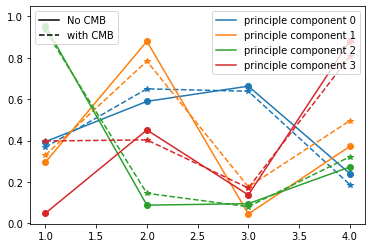

In [202]:
figure=plt.figure()
ax = plt.subplot(111)

nocmb,=plt.plot(1,1,color='black',ls='-')

withcmb,=plt.plot(1,1,color='black',ls='--')

leg2 = plt.legend([nocmb,withcmb],['No CMB','with CMB'],loc='upper left')
for x in range(0,NBIN):
    
    l1,=plt.plot(np.arange(1,5),np.abs(total_trans[x,:,3]/np.linalg.norm(total_trans[x,:,3])),alpha=1,label = 'principle component '+str(x))
    plt.plot(np.arange(1,5),np.abs(total_trans[x,:,3]/np.linalg.norm(total_trans[x,:,3])),'o',color=l1.get_color(),alpha=1)


    plt.plot(np.arange(1,5),np.abs(total_trans_withCMB[x,:,3]/np.linalg.norm(total_trans_withCMB[x,:,3])),color=l1.get_color(),alpha=1,ls='--')
    plt.plot(np.arange(1,5),np.abs(total_trans_withCMB[x,:,3]/np.linalg.norm(total_trans_withCMB[x,:,3])),'*',color=l1.get_color(),alpha=1)
    #plt.axhline(1)
l2=plt.legend()
ax.add_artist(leg2)
